# 네이버 쇼핑 키워드 인사이트

#### 데이터 수집 프로세스
1. 네이버 검색광고 회원가입 및 로그인 : https://searchad.naver.com
2. 광고 시스템 > 도구 > API 사용관리
3. CUSTOMER_ID, API_KEY, SECRET_KEY 획득
4. 네이버 검색 광고 API 매뉴얼 사이트 참고 : http://naver.github.io/searchad-apidoc/#/guides
5. github 페이지 참고
    - https://github.com/naver/searchad-apidoc
    - https://github.com/naver/searchad-apidoc/blob/master/python-sample/examples/ad_management_sample.py
6. 키워드 입력하면 해당 키워드에 대한 데이터 수집

In [1]:
import requests, json, time
import pandas as pd
import signaturehelper
import warnings
warnings.filterwarnings('ignore')

#### 1. 키워드에 대한 검색량 데이터 수집

- 기본정보

In [2]:
BASE_URL = 'https://api.naver.com'
API_KEY = '01000000003f996c6c97adcffe92c9fc5e188061e1408116850b7ece558cd8c431baffc9e2'
SECRET_KEY = 'AQAAAAA/mWxsl63P/pLJ/F4YgGHh7mO+MeZucE9fCB8aQ1QZ8A=='
CUSTOMER_ID = '2488406'

- get_header 정의

In [3]:
def get_header(method, uri, api_key, secret_key, customer_id):
    timestamp = str(round(time.time() * 1000))
    signature = signaturehelper.Signature.generate(timestamp, method, uri, SECRET_KEY)
    return {'Content-Type': 'application/json; charset=UTF-8', 'X-Timestamp': timestamp, 'X-API-KEY': API_KEY, 'X-Customer': str(CUSTOMER_ID), 'X-Signature': signature}

- GET을 이용해 `/keywordstool` 에서 검색량 데이터를 수집

In [4]:
def keyword_master(keyword):
    uri = '/keywordstool'
    method = 'GET'
    response = requests.get(BASE_URL + uri+f'?hintKeywords={keyword}&showDetail=1',
            headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))
    return pd.DataFrame(response.json()['keywordList'])

In [5]:
keyword = "시계"
df = keyword_master(keyword)

In [6]:
df.head()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,monthlyAvePcClkCnt,monthlyAveMobileClkCnt,monthlyAvePcCtr,monthlyAveMobileCtr,plAvgDepth,compIdx
0,시계,135100,268800,76.5,1200.0,0.06,0.48,15,높음
1,티파니앤코목걸이,4250,33000,13.2,245.3,0.34,0.81,15,높음
2,벽시계,8160,66200,51.7,1194.5,0.68,1.94,15,높음
3,손목시계,3680,27200,30.6,371.7,0.90,1.47,15,높음
4,콘솔,6470,38200,55.1,973.7,0.92,2.76,15,높음


#### 2. 검색어에 대한 상품등록수 수집
- item_count : 등록된 상품수
- total_search_count : PC, Mobile 을 합친 검색량

- 상품등록수 수집 함수

In [7]:
def item_count(keyword):
    # 키워드 검색량 데이터 수집
    # 속도 문제로 head() 추가하여 50개만 수집하였습니다.
    df = keyword_master(keyword).head(50)
    df = df[['relKeyword', 'monthlyPcQcCnt','monthlyMobileQcCnt']]
    
    # 상품수 수집
    url = 'https://openapi.naver.com/v1/search/shop.json'
    headers = {"X-Naver-Client-Id": "a8gr1TRU_ZRZCVtibFXX","X-Naver-Client-Secret": "zVdJzKmvLf",}
    data =[]
    for i in df['relKeyword']:
        response = requests.get(url,{'query': f'{i}'},headers=headers)
        data.append(response.json()['total'])
        time.sleep(0.5)
        
    df['item_count'] = data
    
    # 결측치 처리
    df.loc[df['monthlyPcQcCnt'] == '< 10', 'monthlyPcQcCnt'] = 0
    df.loc[df['monthlyMobileQcCnt'] == '< 10', 'monthlyMobileQcCnt'] = 0
    
    # total 계산
    df['total_search_count'] = df[['monthlyPcQcCnt', 'monthlyMobileQcCnt']].sum(axis=1)
    
    # 자료형 변환
    df = df.astype({'total_search_count':'int64'})
    return df

In [8]:
result_df = item_count('시계')

In [9]:
result_df.tail()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count
45,학생시계,400,3890,268479,4290
46,가구인테리어,290,1090,12259922,1380
47,엔틱벽시계,360,4760,362014,5120
48,수입소품,50,420,237488,470
49,스켈레톤시계,340,1530,48040,1870


#### 3. 경쟁률
- 아이템수/검색수 : 높을수록 경쟁이 심한 상품 키워드

In [10]:
data = []
for i in range(len(result_df)):
    try:
        data.append(result_df.iloc[i]['item_count'] / result_df.iloc[i]['total_search_count'])
    except ZeroDivisionError:
        data.append(999999999)        
result_df['competition_rate'] = data

In [11]:
result_df.sort_values(by='competition_rate').head(10)

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count,competition_rate
30,루이비통반지,1070,13400,684,14470,0.047270
20,루이비통목걸이,2470,32500,3163,34970,0.090449
12,티파니팔찌,3500,49200,5051,52700,0.095844
7,티파니목걸이,6110,86900,10873,93010,0.116901
15,티파니앤코팔찌,2050,19500,3039,21550,0.141021
36,루이비통팔찌,2360,28200,5024,30560,0.164398
1,티파니앤코목걸이,4250,33000,7183,37250,0.192832
40,구찌목걸이,2790,31000,9873,33790,0.292187
16,태그호이어까레라,3510,23700,8636,27210,0.317383
22,로만손시계,1090,8550,6026,9640,0.625104


- 시계와 연관 검색어 50개 중에 `competition_rate`가 낮은 상위 10개의 항목은 위 표와 같습니다.
- 다만 일부 자료는 `total_search_count`가 매우 낮기 때문에 일정 `total_search_count`이상의 데이터로 다시 분석을 하였습니다.

In [12]:
result_df[result_df['total_search_count']>10000].sort_values(by='competition_rate').head(10)

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count,competition_rate
30,루이비통반지,1070,13400,684,14470,0.047270
20,루이비통목걸이,2470,32500,3163,34970,0.090449
12,티파니팔찌,3500,49200,5051,52700,0.095844
7,티파니목걸이,6110,86900,10873,93010,0.116901
15,티파니앤코팔찌,2050,19500,3039,21550,0.141021
36,루이비통팔찌,2360,28200,5024,30560,0.164398
1,티파니앤코목걸이,4250,33000,7183,37250,0.192832
40,구찌목걸이,2790,31000,9873,33790,0.292187
16,태그호이어까레라,3510,23700,8636,27210,0.317383
37,소품샵,3870,35900,115700,39770,2.909228


- 다시 검색한 결과 `루이비통반지`가 `competition_rate`가 가장 낮은 것으로 확인되었습니다.
- `루이비통목걸이`, `티파니팔찌` 등도 `competition_rate`가 낮은 것을 확인 할 수 있습니다. 명품 제품은 검색량은 많지만 취급하는 쇼핑몰의 수가 적어서 경쟁률이 낮은 것으로 보입니다.

In [13]:
result_df[result_df['total_search_count']>10000].sort_values(by='competition_rate').head(10).sum()

relKeyword            루이비통반지루이비통목걸이티파니팔찌티파니목걸이티파니앤코팔찌루이비통팔찌티파니앤코목걸이구...
monthlyPcQcCnt                                                    31980
monthlyMobileQcCnt                                               353300
item_count                                                       169226
total_search_count                                               385280
competition_rate                                               4.367514
dtype: object

- 모바일 검색량이 PC 검색량이 11배에 가깝다는 것도 확인할 수 있었습니다. 네이버 쇼핑은 모바일 고객이 압도적으로 많은 것을 확인할 수 있습니다.

# 무신사 제품 경쟁률 분석

In [14]:
df1 = pd.DataFrame()
df1 = pd.concat([df1, item_count('TOFFEE')])
df1 = pd.concat([df1, item_count('YALE')])
df1 = pd.concat([df1, item_count('LAFUDGESTORE')])
df1 = pd.concat([df1, item_count('MELANGE_MASTER')])
df1.tail()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count
22,라퍼지스토어가죽자켓,40,510,104,550
23,라퍼지스토어레더자켓,20,140,104,160
24,피쉬테일파카,190,1220,2327,1410
25,라퍼지스토어롱패딩,0,0,41,0
0,MELANGE_MASTER,0,0,2,0


In [15]:
df2 = pd.DataFrame()
df2 = pd.concat([df2, item_count('토피')])
df2 = pd.concat([df2, item_count('예일')])
df2 = pd.concat([df2, item_count('라퍼지스토어')])
df2 = pd.concat([df2, item_count('멜란지마스터')])
df2.tail()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count
47,오아이오아이후드집업,40,890,18,930
48,스트릿캐주얼브랜드,10,0,13003,10
49,맨즈데일리,30,130,23998,160
0,멜란지마스터,640,2260,401,2900
1,MELANGEMASTER,20,40,0,60


In [101]:
df3 = df1 + df2
df3.head()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count
0,TOFFEE토피,2730,10350,89242,13080
0,YALE예일,4400,23080,97622,27480
0,LAFUDGESTORE라퍼지스토어,5130,26610,1874,31740
0,MELANGE_MASTER멜란지마스터,580,2120,431,2700


In [102]:
data = []
for i in range(len(df3)):
    data.append(df3.iloc[i]['item_count'] / df3.iloc[i]['total_search_count'])
df3['competition_rate'] = data

In [105]:
data = ['TOFFEE','YALE','LAFUDGESTORE','MELANGE_MASTER']
df3['relKeyword'] = data
df3.head()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count,competition_rate
0,TOFFEE,2730,10350,89242,13080,6.822783
0,YALE,4400,23080,97622,27480,3.552475
0,LAFUDGESTORE,5130,26610,1874,31740,0.059042
0,MELANGE_MASTER,580,2120,431,2700,0.159630


In [151]:
df3[['relKeyword', 'item_count', 'total_search_count', 'competition_rate']].head()

,relKeyword,item_count,total_search_count,competition_rate
0,TOFFEE,89242,13080,6.822783
0,YALE,97622,27480,3.552475
0,LAFUDGESTORE,1874,31740,0.059042
0,MELANGE_MASTER,431,2700,0.159630


In [116]:
import matplotlib.pyplot as plt

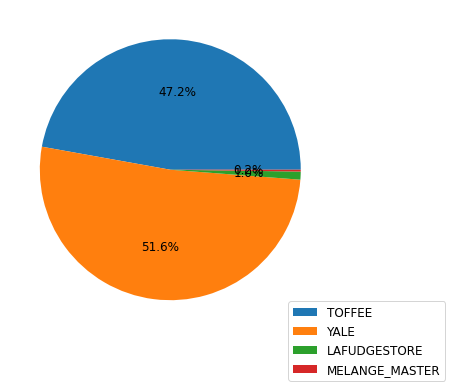

In [148]:
plt.figure(figsize=(8,6))
plt.pie(df3['item_count'], autopct='%.1f%%', textprops={'size': 12})
plt.legend([], labels=df3['relKeyword'], bbox_to_anchor=(1,0), loc="lower right", fontsize=12, bbox_transform=plt.gcf().transFigure)
plt.show()

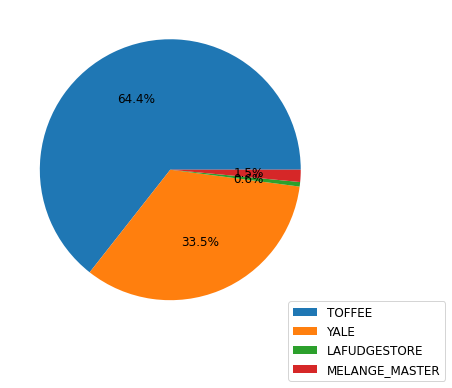

In [149]:
plt.figure(figsize=(8,6))
plt.pie(df3['competition_rate'], autopct='%.1f%%', textprops={'size': 12})
plt.legend([], labels=df3['relKeyword'], bbox_to_anchor=(1,0), loc="lower right", fontsize=12, bbox_transform=plt.gcf().transFigure)
plt.show()

In [155]:
df4 = pd.DataFrame()
df4 = pd.concat([df4, item_count('라퍼지스토어')])
df4 = pd.concat([df4, item_count('M-1965')])
df4 = pd.concat([df4, item_count('피쉬테일')])
df4 = pd.concat([df4, item_count('야상')])
df4.tail()

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count
45,남자야상브랜드,30,180,2539,210
46,남자야상자켓,320,2380,188754,2700
47,여자조끼,210,3090,4513134,3300
48,골프우비,230,1570,70290,1800
49,남자겨울코디,1180,7710,291281,8890


In [157]:
df4.to_csv('df4.csv')

In [158]:
data = []
for i in range(len(df4)):
    data.append(df4.iloc[i]['item_count'] / df4.iloc[i]['total_search_count'])
df4['competition_rate'] = data

In [176]:
result = df4[df4['total_search_count']>10000].sort_values(by='competition_rate').head(10)
result = result.set_index('relKeyword')[['item_count','total_search_count', 'competition_rate']]
result.head(10)

,item_count,total_search_count,competition_rate
relKeyword,,,
마마가리,25,15580,0.001605
도프제이슨,226,19910,0.011351
인사일런스,1025,44900,0.022829
드로우핏,422,15320,0.027546
라퍼지스토어,941,30820,0.030532
더니트컴퍼니,1770,25760,0.068711
쿠어,5904,49000,0.120490
브랜디드,139825,18790,7.441458
항공점퍼,467932,45010,10.396179


In [26]:
data = []
for i in range(len(result_df)):
    try:
        data.append(result_df.iloc[i]['item_count'] / dff.iloc[i]['total_search_count'])
    except ZeroDivisionError:
        data.append(999999999)        
dff['competition_rate'] = data

In [31]:
dff[dff['total_search_count']>3000].sort_values(by='competition_rate').head(20)

,relKeyword,monthlyPcQcCnt,monthlyMobileQcCnt,item_count,total_search_count,competition_rate
15,레이어드티,2420,21200,687423,23620,0.241660
23,남성복,830,2400,176454,3230,0.443653
27,여성면티셔츠,360,7060,2065505,7420,1.596631
29,흰색면티,310,3020,40250,3330,2.575075
1,여자쇼핑몰,3870,14900,234826767,18770,3.067128
3,여성의류,2900,12900,136267861,15800,3.993987
0,옷,6070,35600,236922308,41670,6.123230
20,의류,2190,4290,236923445,6480,8.799228
2,여성티셔츠,1300,18300,22511419,19600,12.686990
13,패션,4910,15800,372908896,20710,14.210430
